In [1]:
import numpy as np
import pandas as pd
import laspy
from sklearn.metrics import precision_recall_fscore_support
from pyntcloud import PyntCloud
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# for widget views
#%matplotlib widget

#### Import and read real point cloud (.las)

In [14]:
# Load the real point cloud
real_pc_path = '/home/Meins/Uni/TUM/SS23/Data Lab/Labelling/Label-Datasets/valid/validation_classified_merge.las'
real_pc = laspy.read(real_pc_path)

In [15]:
# Some quick data information
header_real = real_pc.header
offsets_real = [header_real.x_offset, header_real.y_offset, header_real.z_offset]
print(offsets_real)

# show maximum and minimum x, y, z values (offset substracted)
print(header_real.min - offsets_real)
print(header_real.max - offsets_real)

[670000.0, 5400000.0, 0.0]
[8043.80273438 3798.9362793   412.77938843]
[8102.40722656 3887.64355469  443.08679199]


In [31]:
# Extract the relevant classes from the real point cloud
class_descriptions = {
    1: 'Road',
    2: 'Ground',
    3: 'Road Installations',
    6: 'Wall Surface',
    7: 'Roof Surface',
    8: 'Doors',
    9: 'Windows'
}
relevant_classes = list(class_descriptions.keys())

real_points = real_pc.points
real_labels = real_points['classification']
relevant_indices = np.isin(real_labels, relevant_classes)
relevant_points_real = real_points[relevant_indices]


#### Visualize point cloud

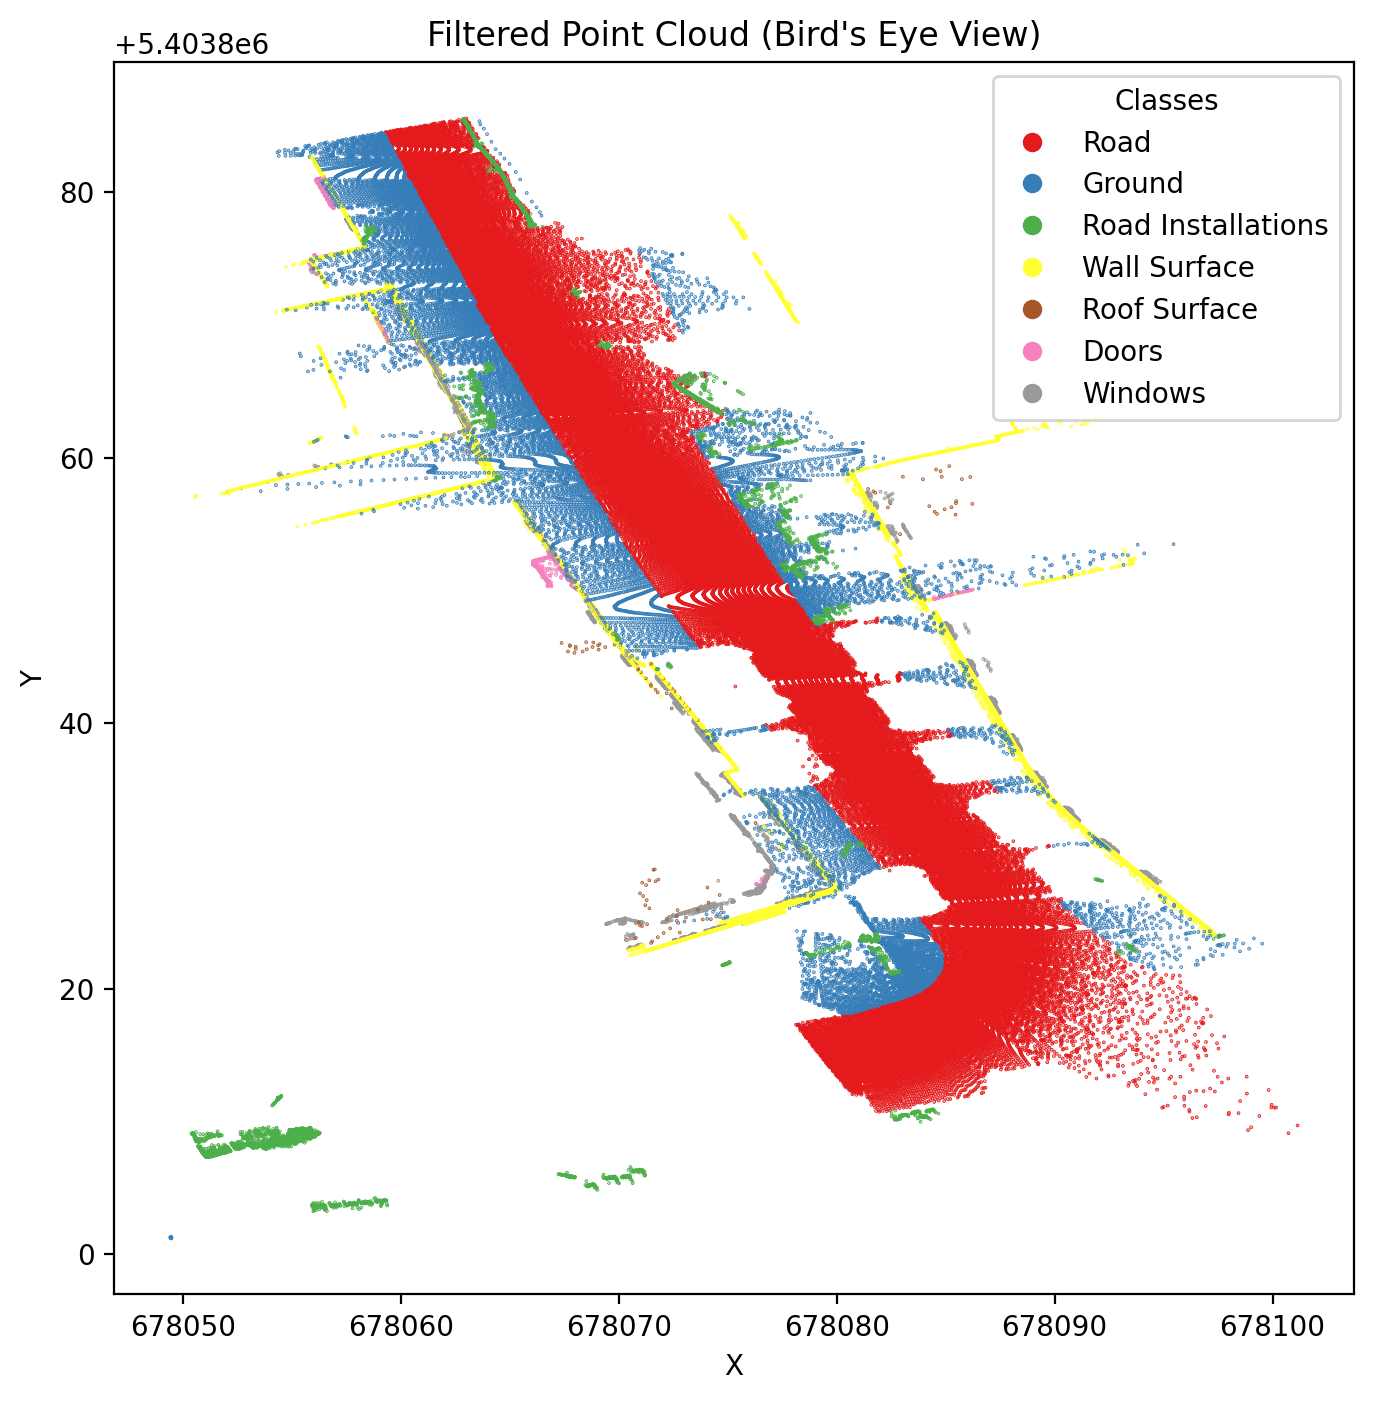

In [32]:
# Set the figure format to support high DPI
%config InlineBackend.figure_format = 'retina'


# Extract x, y coordinates, and semantic labels from the filtered point cloud
x = relevant_points_real['x']
y = relevant_points_real['y']
labels = relevant_points_real['classification']

# Plot every 1000th point with colorization
stride = 100
x_sampled = x[::stride]
y_sampled = y[::stride]
labels_sampled = labels[::stride]

# Create a scatter plot in bird's eye view with colorization
plt.figure(figsize=(8, 8))
scatter = plt.scatter(x_sampled, y_sampled, c=labels_sampled, cmap='Set1', s=0.1)

# Add a legend for the semantic labels
legend_colors = scatter.legend_elements(prop='colors')[0]
plt.legend(legend_colors, list(class_descriptions.values()), loc='upper right', title='Classes')

# Set labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Filtered Point Cloud (Bird\'s Eye View)')

# Show the plot
plt.show()